# Imports

In [1]:
import pandas as pd
from os import *
from os.path import isfile, join
from datetime import datetime
import numpy as np
import pandas as pd
import scipy as scipy
import seaborn as sns
import requests as rqs
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

sns.set(rc={"figure.figsize": (16, 9)})
plt.rcParams['figure.figsize'] = [16, 9]

In [2]:
#!pip install tslearn

# Functions

### IQR

In [4]:
def iqr_anomalies(df, resid, perc, reverse=False):
    standard_resid = (resid - resid.mean()) / resid.std()

    q1, q2 = np.percentile(standard_resid, [100-perc , perc])
    iqr = q1 - q2

    upper = iqr
    lower = -iqr

    # trova anomalie

    if reverse:
      tag1 = 'resid'
      tag2 = 'consumo_attiva'
    else:
      tag2 = 'resid'
      tag1 = 'consumo_attiva'


    tmp = df.copy()
    tmp[tag2] = standard_resid[tag2]
    anomalies = tmp[(tmp[tag2] < lower) | (tmp[tag2] > upper)]


    return anomalies[tag1]

### Isolation Forest

In [5]:
def isolatetheforest(df, outliers_fraction=0.13):
    # Assume that 13% of the entire data set are anomalies 

    model = IsolationForest(contamination=outliers_fraction)
    model.fit(df.values) 

    predicted = model.predict(df.values)
    res = df.copy()
    res['anomalies'] = predicted

    return res

### K-Means

In [7]:
# Write a function that calculates distance between each point and the centroid of the closest cluster
def getDistanceByPoint(data, model):
    """ Function that calculates the distance between a point and centroid of a cluster, 
            returns the distances in pandas series"""
    distance = []
    for i in range(0,len(data)):

        Xa = np.array(data.iloc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)



def kmeans(df, n_clusters, outliers_fraction=0.13):
    # I will start k-means clustering with k=2 as I already know that there are 3 classes of "NORMAL" vs 
    # "NOT NORMAL" which are combination of BROKEN" and"RECOVERING"
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    kmeans.fit(df.values)
    labels = kmeans.predict(df.values)
    unique_elements, counts_elements = np.unique(labels, return_counts=True)
    clusters = np.asarray((unique_elements, counts_elements))

    # Assume that 13% of the entire data set are anomalies 
    # get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
    distance = getDistanceByPoint(df, kmeans)
    # number of observations that equate to the 13% of the entire data set
    number_of_outliers = int(outliers_fraction*len(distance))
    # Take the minimum of the largest 13% of the distances as the threshold
    threshold = distance.nlargest(number_of_outliers).min()
    # anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
    res = df.copy()
    res['anomalies'] = (distance >= threshold).astype(int)
    return res

### General detection 

In [13]:
def get_anomaly(df_ts, df_anomal, anomaly):
    return df_ts[df_anomal['anomalies'] == anomaly]


def anomaly_detection(dfs, resids, reverse=False, save_files=False, show_img=False):
    anomalies = []

    for res in resids:
        for i in range(len(dfs)):

            if reverse:
              anom_k = get_anomaly(pd.DataFrame(res[i]), kmeans(dfs[i], 2, 0.01), 1)
              anom_if = get_anomaly(pd.DataFrame(res[i]), isolatetheforest(dfs[i], 0.01), -1)
              anom_iqr = iqr_anomalies(pd.DataFrame(res[i]), dfs[i], 5, True)
            else:
              anom_k = get_anomaly(dfs[i], kmeans(pd.DataFrame(res[i]), 2, 0.01), 1)
              anom_if = get_anomaly(dfs[i], isolatetheforest(pd.DataFrame(res[i]), 0.01), -1)
              anom_iqr = iqr_anomalies(dfs[i], pd.DataFrame(res[i]), 5)
            

            print(anom_k)

            # intersection
            it1 = anom_if.index.intersection(anom_iqr.index)
            indx = anom_k.index.intersection(it1)
            anom_its = anom_k.loc[indx].drop_duplicates()
            
            # union
            anom_union = pd.concat([anom_k,anom_if, anom_iqr]).drop_duplicates()

            # 2-out-of-3 intersection
            i12 = anom_k.index.intersection(anom_if.index)
            tmp_1 = anom_k.loc[i12] 
            i23 = anom_if.index.intersection(anom_iqr.index)
            tmp_2 = anom_if.loc[i23]
            i13 = anom_k.index.intersection(anom_iqr.index)
            tmp_3 = anom_k.loc[i13] 
            anom_int2 = pd.concat([tmp_1, tmp_2, tmp_3]).drop_duplicates()

            if save_files:
              rev = ''
              if reverse:
                rev = 'reverse'
              anom_its.to_csv('anom_its'+str(i)+'_'+str(rev)+ '.csv')
              anom_union.to_csv('anom_union'+str(i) +'_'+str(rev)+'.csv')
              anom_int2.to_csv('anom_int2'+str(i) +'_'+str(rev)+'.csv')

            if show_img:
              plt.plot(dfs[i], zorder=1)
              plt.scatter(anom_its.index, anom_its['consumo_attiva'], color='r', marker='D', zorder=2)
              plt.title('Intersection')
              plt.show()
              
              plt.plot(dfs[i], zorder=1)
              plt.scatter(anom_union.index, anom_union['consumo_attiva'], color='r', marker='D', zorder=2)
              plt.title('Union')
              plt.show()
              
              plt.plot(dfs[i], zorder=1)
              plt.scatter(anom_int2.index, anom_int2['consumo_attiva'], color='r', marker='D', zorder=2)
              plt.title('Intersection 2-out-of-3')
              plt.show()
            
            anomalies.append(anom_its)
            anomalies.append(anom_union)
            anomalies.append(anom_int2)

            print('Edificio: ')
            print(' - Intersection: ' + str(len(anom_its)))
            print(' - Union: ' + str(len(anom_union)))
            print(' - Intersection 2-out-of-3: ' + str(len(anom_int2)))

    return anomalies

# Code

In [14]:
df = pd.read_csv('energia_cleaned_v6_fill.csv', parse_dates=['dataora'], index_col='dataora')
df_hour_u1 = df[['consumo_attiva_u1']]
df_hour_u6 = df[['consumo_attiva_u6']]

df_hour_u1.columns = ['consumo_attiva']
df_hour_u6.columns = ['consumo_attiva']

In [15]:
tb1_18 = pd.read_csv('tbatsed_u1_2018.csv', parse_dates=['dataora'], index_col='dataora')
tb1_19 = pd.read_csv('tbatsed_u1_2019.csv', parse_dates=['dataora'], index_col='dataora')
tb1_20 = pd.read_csv('tbatsed_u1_2020.csv', parse_dates=['dataora'], index_col='dataora')
tb6_18 = pd.read_csv('tbatsed_u6_2018.csv', parse_dates=['dataora'], index_col='dataora')
tb6_19 = pd.read_csv('tbatsed_u6_2019.csv', parse_dates=['dataora'], index_col='dataora')
tb6_20 = pd.read_csv('tbatsed_u6_2020.csv', parse_dates=['dataora'], index_col='dataora')

tb_u1 = pd.concat([tb1_18, tb1_19, tb1_20])
tb_u6 = pd.concat([tb6_18, tb6_19, tb6_20])

In [16]:
anom_ = anomaly_detection([df_hour_u1, df_hour_u6], [[tb_u1['resid'], tb_u6['resid']]], False, False, False)
anom_rev = anomaly_detection([df_hour_u1, df_hour_u6], [[tb_u1['resid'], tb_u6['resid']]], True, False, False)

                     consumo_attiva
dataora                            
2018-01-01 00:00:00           64.50
2018-01-02 21:00:00           82.05
2018-01-03 22:00:00           76.65
2018-01-05 22:00:00           81.30
2018-02-06 02:00:00           77.70
...                             ...
2020-12-08 10:00:00           57.90
2020-12-10 06:00:00           42.75
2020-12-10 07:00:00           31.05
2020-12-11 08:00:00           47.70
2020-12-11 09:00:00           61.95

[263 rows x 1 columns]
Edificio: 
 - Intersection: 214
 - Union: 578
 - Intersection 2-out-of-3: 236
                     consumo_attiva
dataora                            
2018-01-01 00:00:00         91.7125
2018-02-08 09:00:00        198.9625
2018-02-09 06:00:00         91.3000
2018-02-13 19:00:00        124.4375
2018-02-14 19:00:00        121.6875
...                             ...
2020-07-01 19:00:00         37.1250
2020-07-01 20:00:00         81.4000
2020-07-31 00:00:00          0.0000
2020-08-01 00:00:00        124.025

# IL CONTRARIO

Confronto tra anomalie identificate sulla SS plottate sui residui & anomalie identificate sui residui e plottate sulla SS

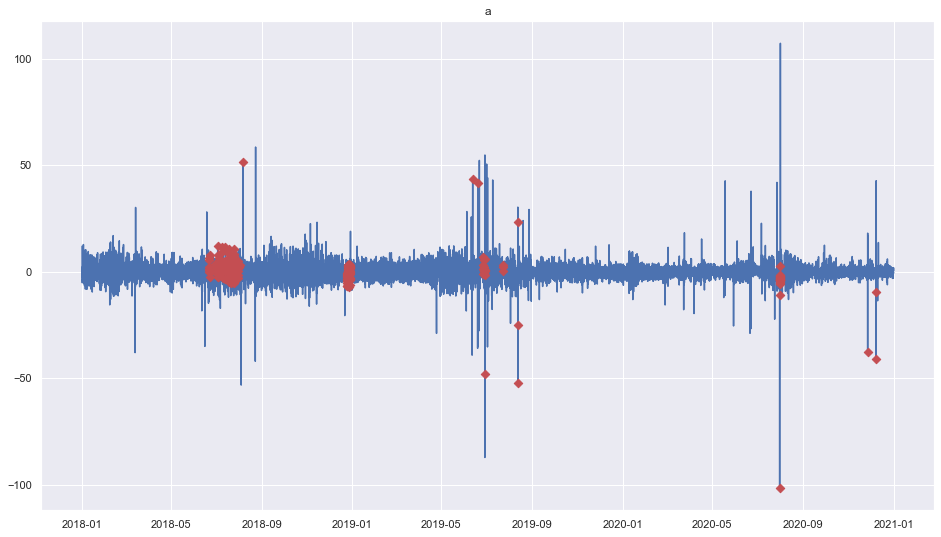

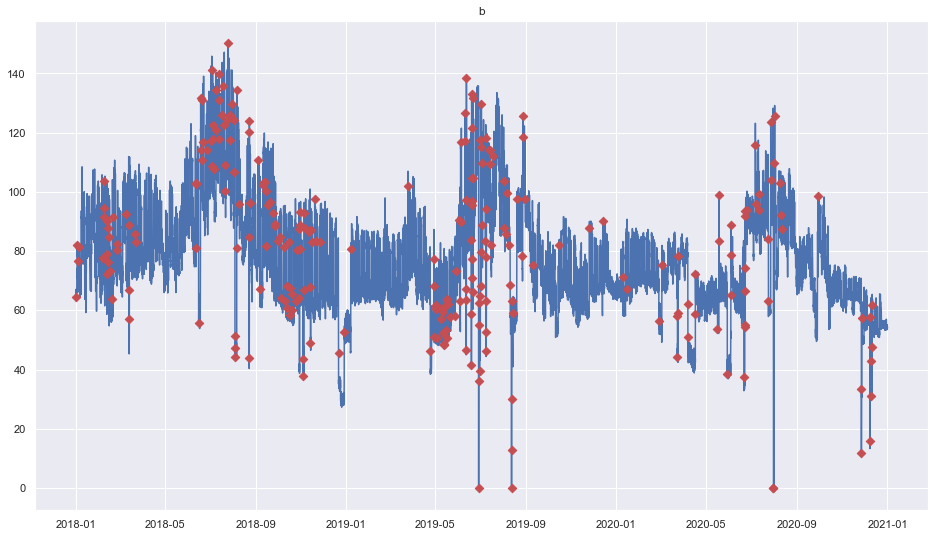

In [17]:
a = get_anomaly(pd.DataFrame(tb_u1['resid']), kmeans(df_hour_u1, 2, 0.01), 1)

b = get_anomaly(df_hour_u1, kmeans(pd.DataFrame(tb_u1['resid']), 2, 0.01), 1)

plt.plot(pd.DataFrame(tb_u1['resid']), zorder=1)
plt.scatter(a.index, a['resid'], color='r', marker='D', zorder=2)
plt.title('a')
plt.show()

plt.plot(df_hour_u1, zorder=1)
plt.scatter(b.index, b['consumo_attiva'], color='r', marker='D', zorder=2)
plt.title('b')
plt.show()

# Grafici per paper



In [18]:
def grafichetti(anomalies, i = 0):
  sns.set(rc={"figure.figsize": (16, 9)})
  plt.rcParams['figure.figsize'] = [16, 9]
  print('anomaly##############')
  fig, axs = plt.subplots(2, 2)

  freq = pd.DataFrame(list(anomalies.index.year), columns=['year'])
  sns.countplot(x='year',data=freq, ax=axs[0, 0], order=[2018, 2019, 2020])

  freq = pd.DataFrame(list(anomalies.index.month), columns=['month'])
  sns.countplot(x='month',data=freq, ax=axs[0, 1], order=list(range(1, 13)))


  freq = pd.DataFrame(list(anomalies.index.dayofweek), columns=['dayofweek'])
  sns.countplot(x='dayofweek',data=freq, ax=axs[1, 0], order=list(range(7)))


  freq = pd.DataFrame(list(anomalies.index.hour), columns=['hour'])
  sns.countplot(x='hour',data=freq, ax=axs[1, 1], order=list(range(24))) 

  plt.savefig('image' + str(i) +'.svg', format='svg', bbox_inches='tight', dpi=1200)
  plt.show()
  

# Multi visual 

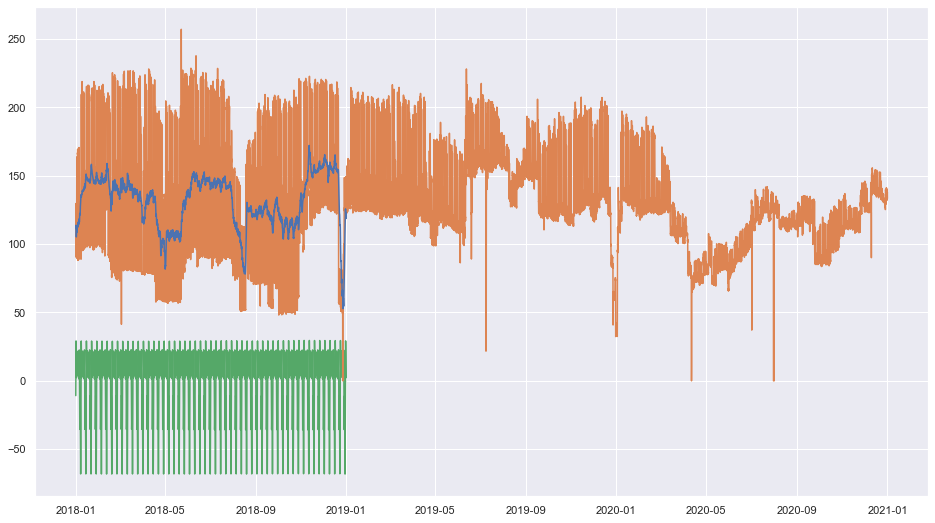

In [20]:
plt.plot(tb6_18['trend'], zorder=3)
plt.plot(df_hour_u6, zorder=2)
plt.plot(tb6_18['season_weekly'],zorder=1)

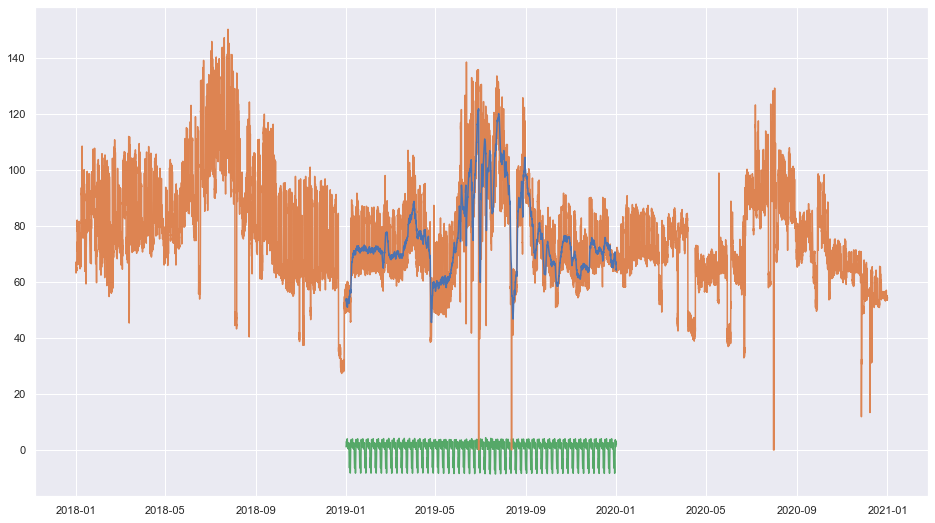

In [21]:
plt.plot(tb1_19['trend'], zorder=3)
plt.plot(df_hour_u1, zorder=2)
plt.plot(tb1_19['season_weekly'],zorder=1)



# filtro per anomalie positive (consumi eccessivi)

In [ ]:
pos_int_u1 = pd.read_csv('anomalie_positive_u1.csv', parse_dates=['dataora'], index_col='dataora')
pos_int_u6 = pd.read_csv('anomalie_positive_u6.csv', parse_dates=['dataora'], index_col='dataora')

In [ ]:
tbat_u6 = pd.read_csv('tbats_u6.csv', parse_dates=['dataora'], index_col='dataora')

In [ ]:
sns.set(rc={"figure.figsize": (21, 6)})
plt.rcParams['figure.figsize'] = [21, 6]

plt.plot(tbat_u1['observed'], zorder=1)
plt.scatter(pos_int_u1.index, pos_int_u1['consumo_attiva'], color='r', marker='D', zorder=2)

plt.savefig('anomalie_u1_positive.svg', format='svg', bbox_inches='tight', dpi=1200)
plt.show()

In [ ]:
sns.set(rc={"figure.figsize": (21, 6)})
plt.rcParams['figure.figsize'] = [21, 6]

plt.plot(tbat_u6['observed'], zorder=1)
plt.scatter(pos_int_u6.index, pos_int_u6['consumo_attiva'], color='r', marker='D', zorder=2)
plt.savefig('anomalie_u6_positive.svg', format='svg', bbox_inches='tight', dpi=1200)
plt.show()

# u1 cose strane

In [ ]:
tbat_u1 = pd.read_csv('tbats_u1.csv', parse_dates=['dataora'], index_col='dataora')
int_u1 = pd.read_csv('u1_intersezione.csv', parse_dates=['dataora'], index_col='dataora')

pos_int_u1 = int_u1[tbat_u1['resid'] > 0]
neg_int_u1 = int_u1[tbat_u1['resid'] <= 0]

In [ ]:
grafichetti(pos_int_u1, 'positivi_u1')
#grafichetti(neg_int_u1)

In [ ]:
int_u1 = pos_int_u1.copy()
sns.set(rc={"figure.figsize": (16, 9)})
plt.rcParams['figure.figsize'] = [16, 9]

In [ ]:
may_u1 = int_u1[int_u1.index.month == 6]
grafichetti(may_u1)
#sebbene ci siano piu anomalie nel 2018, se guardiamo quando avvengono le anomalie nel mese piu' frequente, ovvero giugno, scopriamo
# che queste compaiono maggiormente nel 2019, nello specifico il lunedi e il mercoledi e in maniera costante durante dalla mattina sino al tardo pomeriggio.

In [ ]:
_2018_u1 = int_u1[int_u1.index.year == 2018]
grafichetti(_2018_u1)
#le anomalie rilevate nel 2018 sono distribuite irregolarmente nei mesi.
#e avvengono praticamente solo in settimana, quasi mai nei weekend, molto spesso alle 8 del mattino.

In [ ]:
lunedi_u1 = int_u1[int_u1.index.dayofweek == 0]
grafichetti(lunedi_u1)
#le anomalie del lunedi sono presenti in tutti e tre gli anni, maggiormente nei mesi estivi.
# inoltre, avvengono sempre di giorno, spesso di mattina.

In [ ]:
eight_u1 = int_u1[int_u1.index.hour == 8]
grafichetti(eight_u1)
#le anomalie rilevate alle 8 di mattina sono presenti più spesso il lunedi e il mercoledi, inoltre sono quasi esclusivamente nel 2018 e molto frequenti nei mesi di settembre e novembre.

# u6 cose strane

In [ ]:
int_u6 = pd.read_csv('u6_intersezione.csv', parse_dates=['dataora'], index_col='dataora')

pos_int_u6 = int_u6[tbat_u6['resid'] > 0]
neg_int_u6 = int_u6[tbat_u6['resid'] <= 0]


In [ ]:
grafichetti(pos_int_u6, 'positivi_u6')
#grafichetti(neg_int_u6)

In [ ]:
int_u6 = pos_int_u6.copy()

In [ ]:
no_may_u6 = int_u6[int_u6.index.month != 5]

In [ ]:
may_u6 = int_u6[int_u6.index.month == 5]
grafichetti(may_u6)

#alle 8 di maggio 2018 ci sono un sacco di anomalie, presenti tutti i giorni della settimana tranne la domenica, quindi succedeva qualcosa...

In [ ]:
_4_u6 = int_u6[int_u6.index.hour == 4]
grafichetti(_4_u6)
#alle 4 di mattina dei mesi estivi , ma soprattutto luglio e settembre, ci sono state un sacco di anomalie
#distribuite costantemente nei giorni della settimana

In [ ]:
venerdi_u6 = int_u6[int_u6.index.dayofweek == 5]
grafichetti(venerdi_u6)

#nel 2018 i sabato alle 6 un sacco di anomalie, presenti in maniera costante per tutti i mesi dell'anno
#tranne gennaio e novembre 

# ENTRAMBI EDIFICI 

In [ ]:
u1 = pd.read_csv('anomalie_positive_u1.csv', parse_dates=['dataora'], index_col='dataora')
u6 = pd.read_csv('anomalie_positive_u6.csv', parse_dates=['dataora'], index_col='dataora')

In [ ]:
u1 = u1.resample('D').count()
u6 = u6.resample('D').count()

u1['cons_due'] = u6['consumo_attiva']
new_both = u1[(u1['consumo_attiva'] == u1['cons_due']) & (u1['consumo_attiva'] == 1)]
new_both

In [ ]:
grafichetti(new_both)